In [2]:
import pandas as pd
import numpy as np

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn import preprocessing
from sklearn.linear_model import LinearRegression
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn import svm

import matplotlib.pyplot as plt

from xgboost import XGBClassifier


# Necessary to get names out
SimpleImputer.get_feature_names_out = (lambda self, names=None:
                                       self.feature_names_in_)

d:\python\python38\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [3]:
def get_X_y(data):
    """"
    Returns the X and y of the data

    :returns X, y
    """
    return data.loc[:, data.columns != 'Classification'], data['Classification']



In [4]:
# Creating the pipeline
features_num = [
    "AGNfrac_af", "AGNfrac_af_16", "AGNfrac_cg_s", "AGNfrac_cg_s_16", "AGNfrac_cg_f", "AGNfrac_cg_f_16", 
    "Chi_sq_MpBp", "Chi_sq_AfCg", "Mass_conc", "SFR_conc", "Radio_excess", "Radio_excess_DJS"
]
features_cat = [
    "Spitzer_SN", "Donley", "Lacy", "Stern", "Messias", "KI", "Ch2_Ch4", 
    "Ch4_24mu", "Xray", "Opt_spec", "Extended_radio"
]
features_drop = [
    "Source_Name", "Radio_ID", "AGN_final", "IDOptical", "IDSpitzer"
]
transformer_num = make_pipeline(
    SimpleImputer(),  # there are a few missing values
    StandardScaler(),
)
transformer_cat = make_pipeline(
    SimpleImputer(strategy="most_frequent"),
    OneHotEncoder(handle_unknown='ignore'),
)

preprocessor = make_column_transformer(
    (transformer_num, features_num),
    (transformer_cat, features_cat),
)

In [5]:
data = pd.read_csv("../Data/Cleaned/Combined_secure_class.csv")
X, y = get_X_y(data)
X = X.drop(columns=features_drop)

# Transforming y from categorical to numerical
le = preprocessing.LabelEncoder()
labels = np.unique(y)
y = le.fit_transform(y)

C:\Users\jespe\AppData\Local\Temp\ipykernel_10748\22415563.py:1: DtypeWarning: Columns (30,31) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv("../Data/Cleaned/Combined_secure_class.csv")


In [6]:
# Creating training and testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7)

In [7]:
# Transforming the data
X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)

# Random Forest

In [32]:
clf = RandomForestClassifier(n_estimators=10, class_weight=None)
clf.fit(X_train, y_train)

RandomForestClassifier(n_estimators=10)

In [33]:
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred, target_names=labels, digits=4))

                                                      precision    recall  f1-score   support

      jet-mode radio AGN/low-excitation radio galaxy     0.9574    0.9814    0.9693      3824
quasar-like radio AGN / high-excitation radio galaxy     0.8218    0.8623    0.8416       385
                                     radio-quiet AGN     0.9304    0.9281    0.9293      2032
                                 star-forming galaxy     0.9913    0.9849    0.9880     17042

                                            accuracy                         0.9773     23283
                                           macro avg     0.9252    0.9392    0.9320     23283
                                        weighted avg     0.9776    0.9773    0.9774     23283



[]

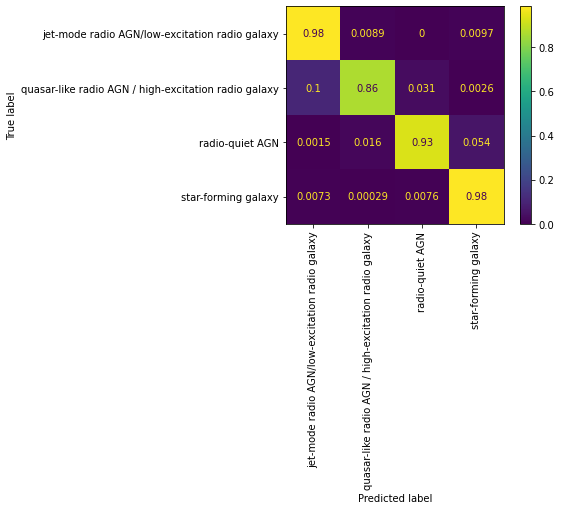

In [34]:
cm = confusion_matrix(y_test, y_pred, normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot()
plt.xticks(rotation = 90)
plt.plot()

In [35]:
random_forest_feature_importance = pd.DataFrame(
    np.array([preprocessor.get_feature_names_out(), clf.feature_importances_]).T,
                                               columns=['Feature', 'Importance'])
random_forest_feature_importance = random_forest_feature_importance.sort_values(by=['Importance'], ascending=False)

[Text(0, 0, 'pipeline-1__Radio_excess'),
 Text(1, 0, 'pipeline-1__Radio_excess_DJS'),
 Text(2, 0, 'pipeline-1__AGNfrac_cg_s_16'),
 Text(3, 0, 'pipeline-1__AGNfrac_af_16'),
 Text(4, 0, 'pipeline-1__AGNfrac_af'),
 Text(5, 0, 'pipeline-1__SFR_conc'),
 Text(6, 0, 'pipeline-1__AGNfrac_cg_f_16'),
 Text(7, 0, 'pipeline-1__AGNfrac_cg_s'),
 Text(8, 0, 'pipeline-1__Chi_sq_MpBp'),
 Text(9, 0, 'pipeline-2__Extended_radio_0.0'),
 Text(10, 0, 'pipeline-1__Mass_conc'),
 Text(11, 0, 'pipeline-1__Chi_sq_AfCg'),
 Text(12, 0, 'pipeline-2__Extended_radio_1.0'),
 Text(13, 0, 'pipeline-2__Opt_spec_1.0'),
 Text(14, 0, 'pipeline-2__Opt_spec_0.0'),
 Text(15, 0, 'pipeline-1__AGNfrac_cg_f'),
 Text(16, 0, 'pipeline-2__Xray_0.0'),
 Text(17, 0, 'pipeline-2__Xray_1.0'),
 Text(18, 0, 'pipeline-2__Donley_0.0'),
 Text(19, 0, 'pipeline-2__Spitzer_SN_2.0'),
 Text(20, 0, 'pipeline-2__Messias_1.0'),
 Text(21, 0, 'pipeline-2__Lacy_1.0'),
 Text(22, 0, 'pipeline-2__KI_-99.0'),
 Text(23, 0, 'pipeline-2__Stern_1.0'),
 Text(24, 

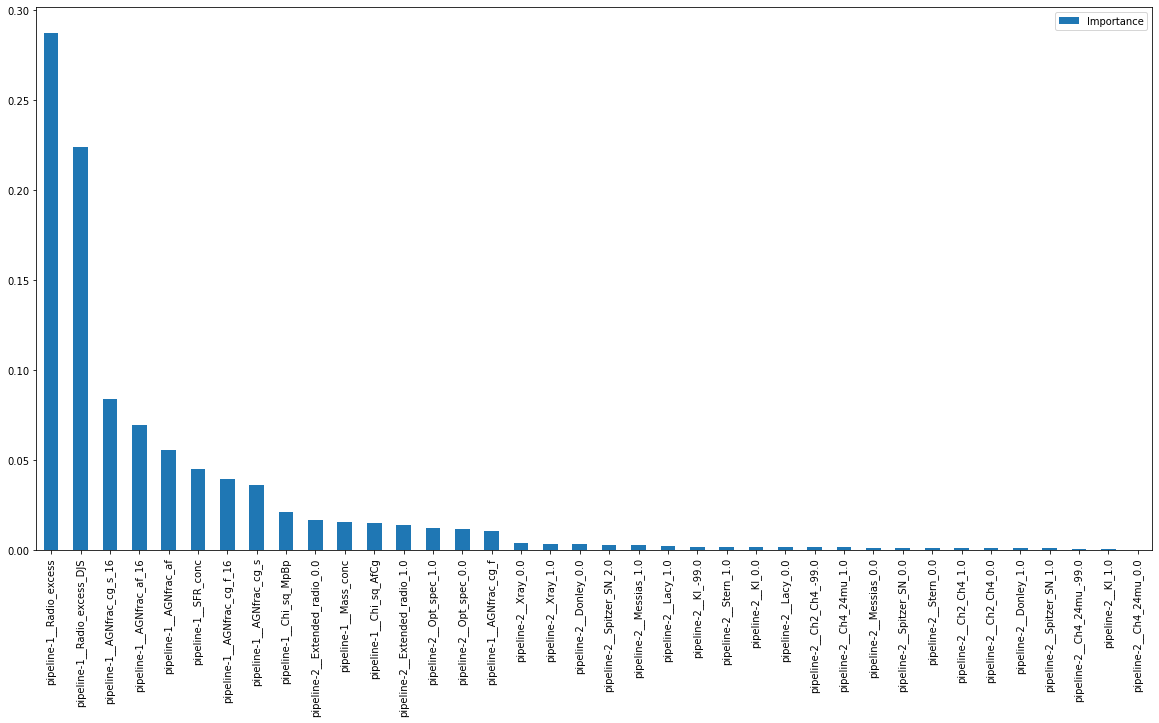

In [36]:
ax = random_forest_feature_importance.plot(kind='bar', figsize=(20,10))
ax.set_xticklabels(random_forest_feature_importance.Feature)

In [40]:
random_forest_feature_importance['cumulative_sum'] = random_forest_feature_importance['Importance'].cumsum()
random_forest_feature_importance = random_forest_feature_importance.reset_index()
random_forest_feature_importance

,index,Feature,Importance,cumulative_sum
0,10,pipeline-1__Radio_excess,0.287643,0.287643
1,11,pipeline-1__Radio_excess_DJS,0.223837,0.51148
2,3,pipeline-1__AGNfrac_cg_s_16,0.084004,0.595485
3,1,pipeline-1__AGNfrac_af_16,0.069839,0.665323
4,0,pipeline-1__AGNfrac_af,0.055582,0.720905
5,9,pipeline-1__SFR_conc,0.044983,0.765888
6,5,pipeline-1__AGNfrac_cg_f_16,0.039791,0.805679
7,2,pipeline-1__AGNfrac_cg_s,0.036429,0.842108
8,6,pipeline-1__Chi_sq_MpBp,0.021147,0.863255
9,36,pipeline-2__Extended_radio_0.0,0.016855,0.88011


# XGBoost

In [25]:
model = XGBClassifier(use_label_encoder=False, max_depth=7)
model.fit(X_train, y_train, early_stopping_rounds=10, eval_set=[(X_test, y_test)], verbose=True)

[22:04:33] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:0.87766
[1]	validation_0-mlogloss:0.61495
[2]	validation_0-mlogloss:0.44870
[3]	validation_0-mlogloss:0.33641
[4]	validation_0-mlogloss:0.25755
[5]	validation_0-mlogloss:0.20154
[6]	validation_0-mlogloss:0.16099
[7]	validation_0-mlogloss:0.13147
[8]	validation_0-mlogloss:0.10976
[9]	validation_0-mlogloss:0.09378
[10]	validation_0-mlogloss:0.08193
[11]	validation_0-mlogloss:0.07279
[12]	validation_0-mlogloss:0.06580
[13]	validation_0-mlogloss:0.06064
[14]	validation_0-mlogloss:0.05667
[15]	validation_0-mlogloss:0.05380
[16]	validation_0-mlogloss:0.05142
[17]	validation_0-mlogloss:0.04954
[18]	validation_0-mlogloss:0.04813
[19]	validation_0-mlogloss:0.04692

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=7, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=8,
              num_parallel_tree=1, objective='multi:softprob', predictor='auto',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=None,
              subsample=1, tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

In [26]:
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred, target_names=labels, digits=4))

                                                      precision    recall  f1-score   support

      jet-mode radio AGN/low-excitation radio galaxy     0.9771    0.9827    0.9799      3824
quasar-like radio AGN / high-excitation radio galaxy     0.8448    0.8909    0.8673       385
                                     radio-quiet AGN     0.9459    0.9542    0.9500      2032
                                 star-forming galaxy     0.9939    0.9903    0.9921     17042

                                            accuracy                         0.9843     23283
                                           macro avg     0.9404    0.9545    0.9473     23283
                                        weighted avg     0.9845    0.9843    0.9844     23283



[]

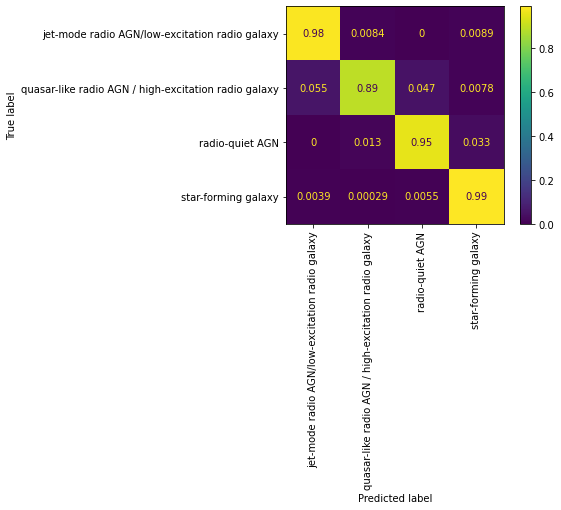

In [27]:
cm = confusion_matrix(y_test, y_pred, normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot()
plt.xticks(rotation = 90)
plt.plot()

In [30]:
xgboost_feature_importance = pd.DataFrame(
    np.array([preprocessor.get_feature_names_out(), model.feature_importances_]).T,
                                               columns=['Feature', 'Importance'])
xgboost_feature_importance = xgboost_feature_importance.sort_values(by=['Importance'], ascending=False)

[Text(0, 0, 'pipeline-1__Radio_excess'),
 Text(1, 0, 'pipeline-1__AGNfrac_af_16'),
 Text(2, 0, 'pipeline-1__AGNfrac_cg_s_16'),
 Text(3, 0, 'pipeline-2__Extended_radio_0.0'),
 Text(4, 0, 'pipeline-2__Opt_spec_0.0'),
 Text(5, 0, 'pipeline-2__Xray_0.0'),
 Text(6, 0, 'pipeline-2__Messias_0.0'),
 Text(7, 0, 'pipeline-2__Ch2_Ch4_-99.0'),
 Text(8, 0, 'pipeline-2__Spitzer_SN_0.0'),
 Text(9, 0, 'pipeline-2__Spitzer_SN_2.0'),
 Text(10, 0, 'pipeline-1__Chi_sq_MpBp'),
 Text(11, 0, 'pipeline-1__Chi_sq_AfCg'),
 Text(12, 0, 'pipeline-2__Lacy_0.0'),
 Text(13, 0, 'pipeline-2__KI_-99.0'),
 Text(14, 0, 'pipeline-2__Ch4_24mu_1.0'),
 Text(15, 0, 'pipeline-2__Ch2_Ch4_1.0'),
 Text(16, 0, 'pipeline-1__AGNfrac_cg_s'),
 Text(17, 0, 'pipeline-1__Radio_excess_DJS'),
 Text(18, 0, 'pipeline-2__Ch2_Ch4_0.0'),
 Text(19, 0, 'pipeline-1__SFR_conc'),
 Text(20, 0, 'pipeline-1__AGNfrac_af'),
 Text(21, 0, 'pipeline-2__Donley_0.0'),
 Text(22, 0, 'pipeline-2__Ch4_24mu_-99.0'),
 Text(23, 0, 'pipeline-1__AGNfrac_cg_f'),
 Text(

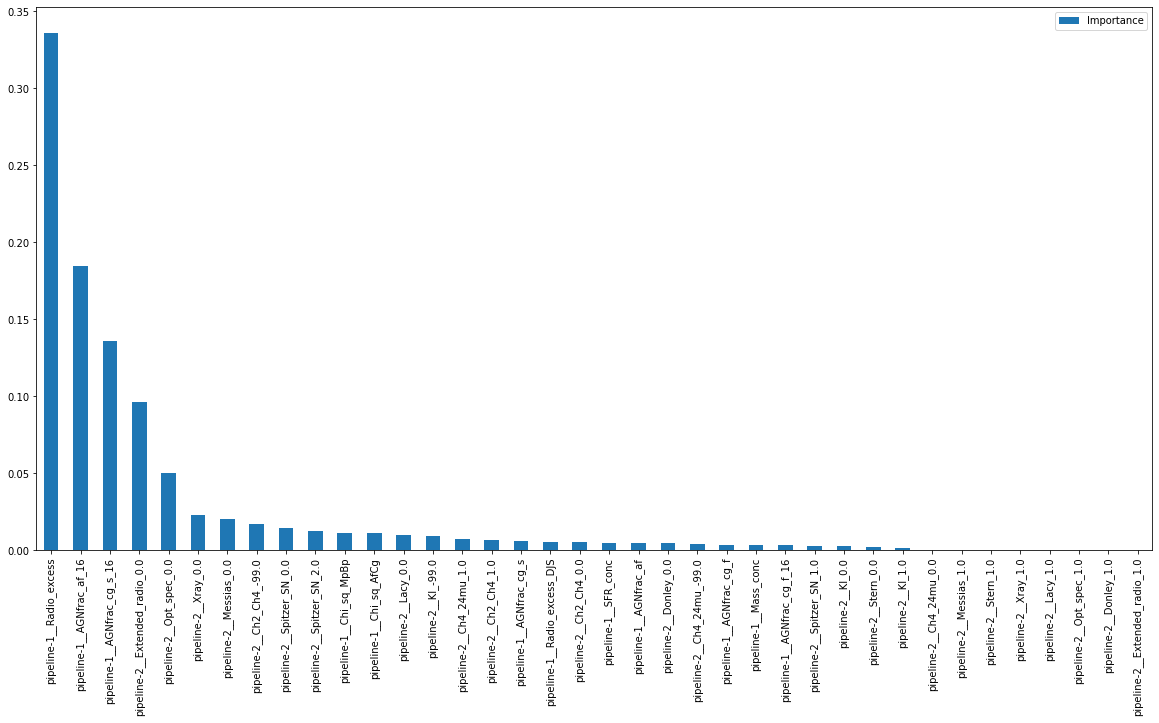

In [31]:
ax = xgboost_feature_importance.plot(kind='bar', figsize=(20,10))
ax.set_xticklabels(xgboost_feature_importance.Feature)

In [39]:
xgboost_feature_importance['cumulative_sum'] = xgboost_feature_importance['Importance'].cumsum()
xgboost_feature_importance = xgboost_feature_importance.reset_index()
xgboost_feature_importance

,index,Feature,Importance,cumulative_sum
0,10,pipeline-1__Radio_excess,0.336146,0.336146
1,1,pipeline-1__AGNfrac_af_16,0.184317,0.520463
2,3,pipeline-1__AGNfrac_cg_s_16,0.135927,0.65639
3,36,pipeline-2__Extended_radio_0.0,0.096027,0.752418
4,34,pipeline-2__Opt_spec_0.0,0.049935,0.802353
5,32,pipeline-2__Xray_0.0,0.023158,0.825511
6,21,pipeline-2__Messias_0.0,0.020303,0.845814
7,26,pipeline-2__Ch2_Ch4_-99.0,0.016767,0.862581
8,12,pipeline-2__Spitzer_SN_0.0,0.014518,0.877099
9,14,pipeline-2__Spitzer_SN_2.0,0.012301,0.8894


# SVM

In [18]:
clf = svm.SVC()
clf.fit(X_train, y_train)

SVC()

In [19]:
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred, target_names=labels, digits=4))

                                                      precision    recall  f1-score   support

      jet-mode radio AGN/low-excitation radio galaxy     0.9676    0.9446    0.9559      3824
quasar-like radio AGN / high-excitation radio galaxy     0.8481    0.6961    0.7646       385
                                     radio-quiet AGN     0.9085    0.9139    0.9112      2032
                                 star-forming galaxy     0.9798    0.9883    0.9840     17042

                                            accuracy                         0.9698     23283
                                           macro avg     0.9260    0.8857    0.9039     23283
                                        weighted avg     0.9694    0.9698    0.9694     23283



[]

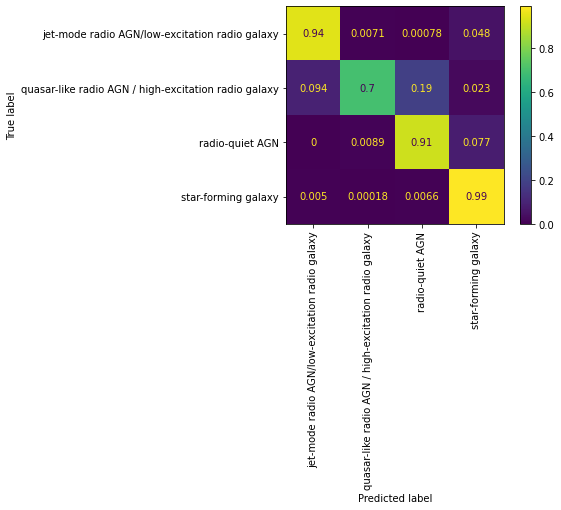

In [20]:
cm = confusion_matrix(y_test, y_pred, normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot()
plt.xticks(rotation = 90)
plt.plot()

# Single feature

In [49]:
Radio_excess = X['Radio_excess']

In [50]:
# Creating training and testing set
X_train_re, X_test_re, y_train_re, y_test_re = train_test_split(Radio_excess, y, train_size=0.7)

In [51]:
model = XGBClassifier(use_label_encoder=False, max_depth=7)
model.fit(X_train_re, y_train_re, early_stopping_rounds=10, eval_set=[(X_test_re, y_test_re)], verbose=True)

[22:30:05] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.00103
[1]	validation_0-mlogloss:0.79868
[2]	validation_0-mlogloss:0.67361
[3]	validation_0-mlogloss:0.59199
[4]	validation_0-mlogloss:0.53721
[5]	validation_0-mlogloss:0.49980
[6]	validation_0-mlogloss:0.47374
[7]	validation_0-mlogloss:0.45536
[8]	validation_0-mlogloss:0.44205
[9]	validation_0-mlogloss:0.43220
[10]	validation_0-mlogloss:0.42477
[11]	validation_0-mlogloss:0.41903
[12]	validation_0-mlogloss:0.41452
[13]	validation_0-mlogloss:0.41091
[14]	validation_0-mlogloss:0.40800
[15]	validation_0-mlogloss:0.40564
[16]	validation_0-mlogloss:0.40375
[17]	validation_0-mlogloss:0.40221
[18]	validation_0-mlogloss:0.40097
[19]	validation_0-mlogloss:0.39996

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=7, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=8,
              num_parallel_tree=1, objective='multi:softprob', predictor='auto',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=None,
              subsample=1, tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

In [48]:
y_pred = model.predict(X_test_re)
print(classification_report(y_test_re, y_pred, target_names=labels, digits=4))

                                                      precision    recall  f1-score   support

      jet-mode radio AGN/low-excitation radio galaxy     0.8622    0.9696    0.9128      3853
quasar-like radio AGN / high-excitation radio galaxy     0.0000    0.0000    0.0000       424
                                     radio-quiet AGN     0.4000    0.0010    0.0020      2042
                                 star-forming galaxy     0.8868    0.9904    0.9358     16964

                                            accuracy                         0.8821     23283
                                           macro avg     0.5373    0.4903    0.4626     23283
                                        weighted avg     0.8239    0.8821    0.8330     23283



d:\python\python38\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\python\python38\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\python\python38\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


array([0, 0, 0, ..., 3, 2, 2])